In [149]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("EcommerceClassifier").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")   

data_path = "/Users/kk/Desktop/001/BigDataAnalysis/big_data_analysis/data/ecommerce_data.csv"


In [150]:

df = spark.read.csv(data_path, header=True, inferSchema=True)
df.show(5)
df.printSchema()


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

root
 |-- InvoiceNo: string (nullable = true)
 |

In [151]:
# 选择标签列：优先选类别型且唯一值少的字段
# Select TAB Column: Prioritize categorical fields with fewer unique values
from pyspark.sql.types import StringType
cat_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
label_col = None

for c in cat_cols:
    uniq = df.select(c).distinct().count()
    if 2 <= uniq <= 10:  
        label_col = c
        break
if label_col is None:
    label_col = df.columns[-1]  
print(f"Auto selected label column: {label_col}")


Auto selected label column: Country


In [152]:
# Set the label column (标签列)
label_col = "Country"

# Exclude only truly useless or high-cardinality columns
# 只排除完全无用或基数极高的列，保留有信息量的特征
high_card_cols = ["InvoiceNo", "StockCode", "Description", "InvoiceDate"]

feature_cols = [c for c in df.columns if c != label_col and c not in high_card_cols]

print("Label column name:", label_col)
print("Cleaned feature columns:", feature_cols)


Label column name: Country
Cleaned feature columns: ['Quantity', 'UnitPrice', 'CustomerID']


In [153]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, month, dayofweek, hour, when

# 1. 新增衍生特征
# 1. Add derived features
df = df.withColumn("OrderAmount", col("Quantity") * col("UnitPrice"))
df = df.withColumn("month", month("InvoiceDate"))
df = df.withColumn("dayofweek", dayofweek("InvoiceDate"))
df = df.withColumn("hour", hour("InvoiceDate"))
df = df.withColumn(
    "quantity_bin",
    when(df.Quantity < 5, 0).when(df.Quantity < 20, 1).otherwise(2)
)

# 2. 明确所有用于建模的特征列（
# 2. Specify all feature columns for modeling
feature_cols = [
    "Quantity",           # 购买数量 / Quantity purchased
    "UnitPrice",          # 单价 / Unit price
    "OrderAmount",        # 订单金额 / Order amount
    "month",              # 月份 / Month
    "dayofweek",          # 星期几 / Day of week
    "hour",               # 小时 / Hour
    "quantity_bin"        # 数量分箱 / Quantity bin
    # 如果你想加商品类别: "StockCode"  # Add StockCode if needed (StringIndexer required)
]

# 3. 标签列名
# 3. Label column name
label_col = "Country"

# 4. 所有数值特征转为 double 类型
# 4. Cast all numeric features to double type
for c in feature_cols:
    df = df.withColumn(c, df[c].cast("double"))

# 5. 填补缺失值
# 5. Fill missing values with 0 to avoid null issues
df = df.fillna(0, subset=feature_cols)

# 6. 找出所有类别（字符串）型特征列
# 6. Find all categorical (string type) feature columns
cat_cols = [c for c in feature_cols if dict(df.dtypes)[c] == "string"]

# 7. 对所有类别特征编码（非标签）
# 7. Encode all categorical features (except label)
indexers = [
    StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep")
    for c in cat_cols
]

# 8. 标签编码
# 8. Encode the label column
label_indexer = StringIndexer(inputCol=label_col, outputCol="label", handleInvalid="keep")

# 9. 汇总特征列（数值型+已编码的类别型）
# 9. Gather all features (numeric + encoded categorical)
indexed_feature_cols = [
    c+"_idx" if c in cat_cols else c
    for c in feature_cols
]

# 10. 构建特征向量
# 10. Build feature vector
assembler = VectorAssembler(inputCols=indexed_feature_cols, outputCol="features")

# 11. 建立处理流水线
# 11. Build the processing pipeline
pipeline = Pipeline(stages=indexers + [label_indexer, assembler])
data_prep = pipeline.fit(df).transform(df)

# 12. 检查特征输出，多维为正常现象
# 12. Check feature output; multi-dimensional vector is expected
data_prep.select("features", "label").show(5, truncate=False)


+---------------------------------------------+-----+
|features                                     |label|
+---------------------------------------------+-----+
|[6.0,2.55,15.299999999999999,0.0,0.0,0.0,1.0]|0.0  |
|[6.0,3.39,20.34,0.0,0.0,0.0,1.0]             |0.0  |
|[8.0,2.75,22.0,0.0,0.0,0.0,1.0]              |0.0  |
|[6.0,3.39,20.34,0.0,0.0,0.0,1.0]             |0.0  |
|[6.0,3.39,20.34,0.0,0.0,0.0,1.0]             |0.0  |
+---------------------------------------------+-----+
only showing top 5 rows



In [154]:
# 1. 计算0类需要采样的比例
# 1. Calculate the sampling ratio for class 0
total_0 = data_prep.filter(data_prep["label"] == 0.0).count()
keep_frac = 8000 / total_0   
# The sampling fraction for class 0 to keep about 8000 samples

# 2. 构建采样比例字典
# 2. Build the sampling fractions dictionary
all_labels = [row['label'] for row in data_prep.select("label").distinct().collect()]
fractions = {float(l): 1.0 for l in all_labels}  
# Keep all other classes
fractions[0.0] = keep_frac  
# Only sample a portion of class 0

# 3. 采样
# 3. Sample the data
data_sampled = data_prep.sampleBy("label", fractions, seed=42)

# 4. 检查采样结果
# 4. Check the sampling result
data_sampled.groupBy("label").count().orderBy("count", ascending=False).show()



train_df, test_df = data_prep.randomSplit([0.7, 0.3], seed=42)


+-----+-----+
|label|count|
+-----+-----+
|  1.0| 9495|
|  2.0| 8557|
|  3.0| 8196|
|  0.0| 8083|
|  4.0| 2533|
|  5.0| 2371|
|  6.0| 2069|
|  7.0| 2002|
|  8.0| 1519|
|  9.0| 1259|
| 10.0| 1086|
| 11.0|  803|
| 12.0|  758|
| 13.0|  695|
| 14.0|  622|
| 15.0|  462|
| 16.0|  446|
| 17.0|  401|
| 18.0|  389|
| 19.0|  358|
+-----+-----+
only showing top 20 rows



In [155]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    labelCol="label",
    featuresCol="features",
    maxDepth=5,
    maxBins=4500   
)
dt_model = dt.fit(train_df)
dt_pred = dt_model.transform(test_df)




In [156]:

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. 实例化决策树模型
# 1. Instantiate the decision tree model
dt = DecisionTreeClassifier(
    labelCol="label",           
    featuresCol="features",    
    maxDepth=5,                 
    maxBins=4500                 
)

# 2. 模型训练
# 2. Model Training
dt_model = dt.fit(train_df)

# 3. 模型预测
# 3. Model Prediction
dt_pred = dt_model.transform(test_df)

# 4. 模型评估（准确率）
# 4. Model Evaluation (Accuracy)
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
dt_accuracy = evaluator.evaluate(dt_pred)
print("Decision Tree Test Accuracy = ", dt_accuracy)


Decision Tree Test Accuracy =  0.9142749640704897


In [157]:
# 检查标签唯一值数量
# Check the number of unique values for labels
num_classes = train_df.select('label').distinct().count()

if num_classes == 2:
    try:
        svm = LinearSVC(labelCol="label", featuresCol="features", maxIter=20, regParam=0.1)
        svm_model = svm.fit(train_df)
        svm_pred = svm_model.transform(test_df)
        has_svm = True
    except Exception as e:
        print("SVM error:", e)
        has_svm = False
else:
    print(f"SVM skipped: label has {num_classes} classes (must be exactly 2 for LinearSVC)")
    has_svm = False


SVM skipped: label has 38 classes (must be exactly 2 for LinearSVC)


In [158]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# 决策树准确率
# Decision Tree Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_acc = evaluator.evaluate(dt_pred)
print("Decision Tree Test Accuracy: {:.2f}%".format(dt_acc * 100))

# 决策树混淆矩阵
# Decision Tree Confusion Matrix
dt_pred.groupBy("label", "prediction").count().show()

# SVM
if has_svm:
    bin_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    svm_auc = bin_evaluator.evaluate(svm_pred)
    svm_acc = evaluator.evaluate(svm_pred)
    print("SVM (LinearSVC) Test Accuracy: {:.2f}%".format(svm_acc * 100))
    print("SVM (LinearSVC) AUC: {:.2f}".format(svm_auc))
    svm_pred.groupBy("label", "prediction").count().show()


Decision Tree Test Accuracy: 91.43%
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  2.0|       0.0|  2614|
| 36.0|       0.0|    11|
| 14.0|       0.0|   208|
| 19.0|       0.0|   117|
| 10.0|       0.0|   324|
| 21.0|       0.0|    84|
| 13.0|       0.0|   183|
|  8.0|       0.0|   465|
|  9.0|       0.0|   344|
| 20.0|       0.0|    95|
|  1.0|       0.0|  2741|
| 15.0|       0.0|   133|
| 17.0|       0.0|   129|
| 12.0|       0.0|   233|
| 33.0|       0.0|    13|
| 11.0|       0.0|   241|
|  7.0|       0.0|   622|
|  0.0|       0.0|148225|
| 18.0|       0.0|   138|
|  4.0|       0.0|   744|
+-----+----------+------+
only showing top 20 rows



+---------------+------------------+------------------+
|        Country|    avg(UnitPrice)|     avg(Quantity)|
+---------------+------------------+------------------+
|         Sweden|3.9108874458874454| 77.13636363636364|
|        Germany|3.9669299631384787|12.369457609268036|
|         France| 5.028864087881273| 12.91106696272058|
|        Belgium| 3.644335427742873| 11.18994683421943|
|        Finland| 5.448705035971222|15.346762589928058|
|          Italy| 4.831120797011208| 9.961394769613948|
|           EIRE|  5.91107735480721| 17.40324548560273|
|      Lithuania|2.8411428571428576| 18.62857142857143|
|         Norway| 6.012025782688767|17.722836095764272|
|          Spain| 4.987544413738653| 10.58981444926964|
|        Denmark| 3.256940874035989| 21.04884318766067|
|        Iceland|2.6440109890109897|13.505494505494505|
|         Israel|3.6331313131313143|14.656565656565656|
|Channel Islands| 4.932124010554092|12.505277044854882|
|         Cyprus| 6.302363344051452|10.155948553

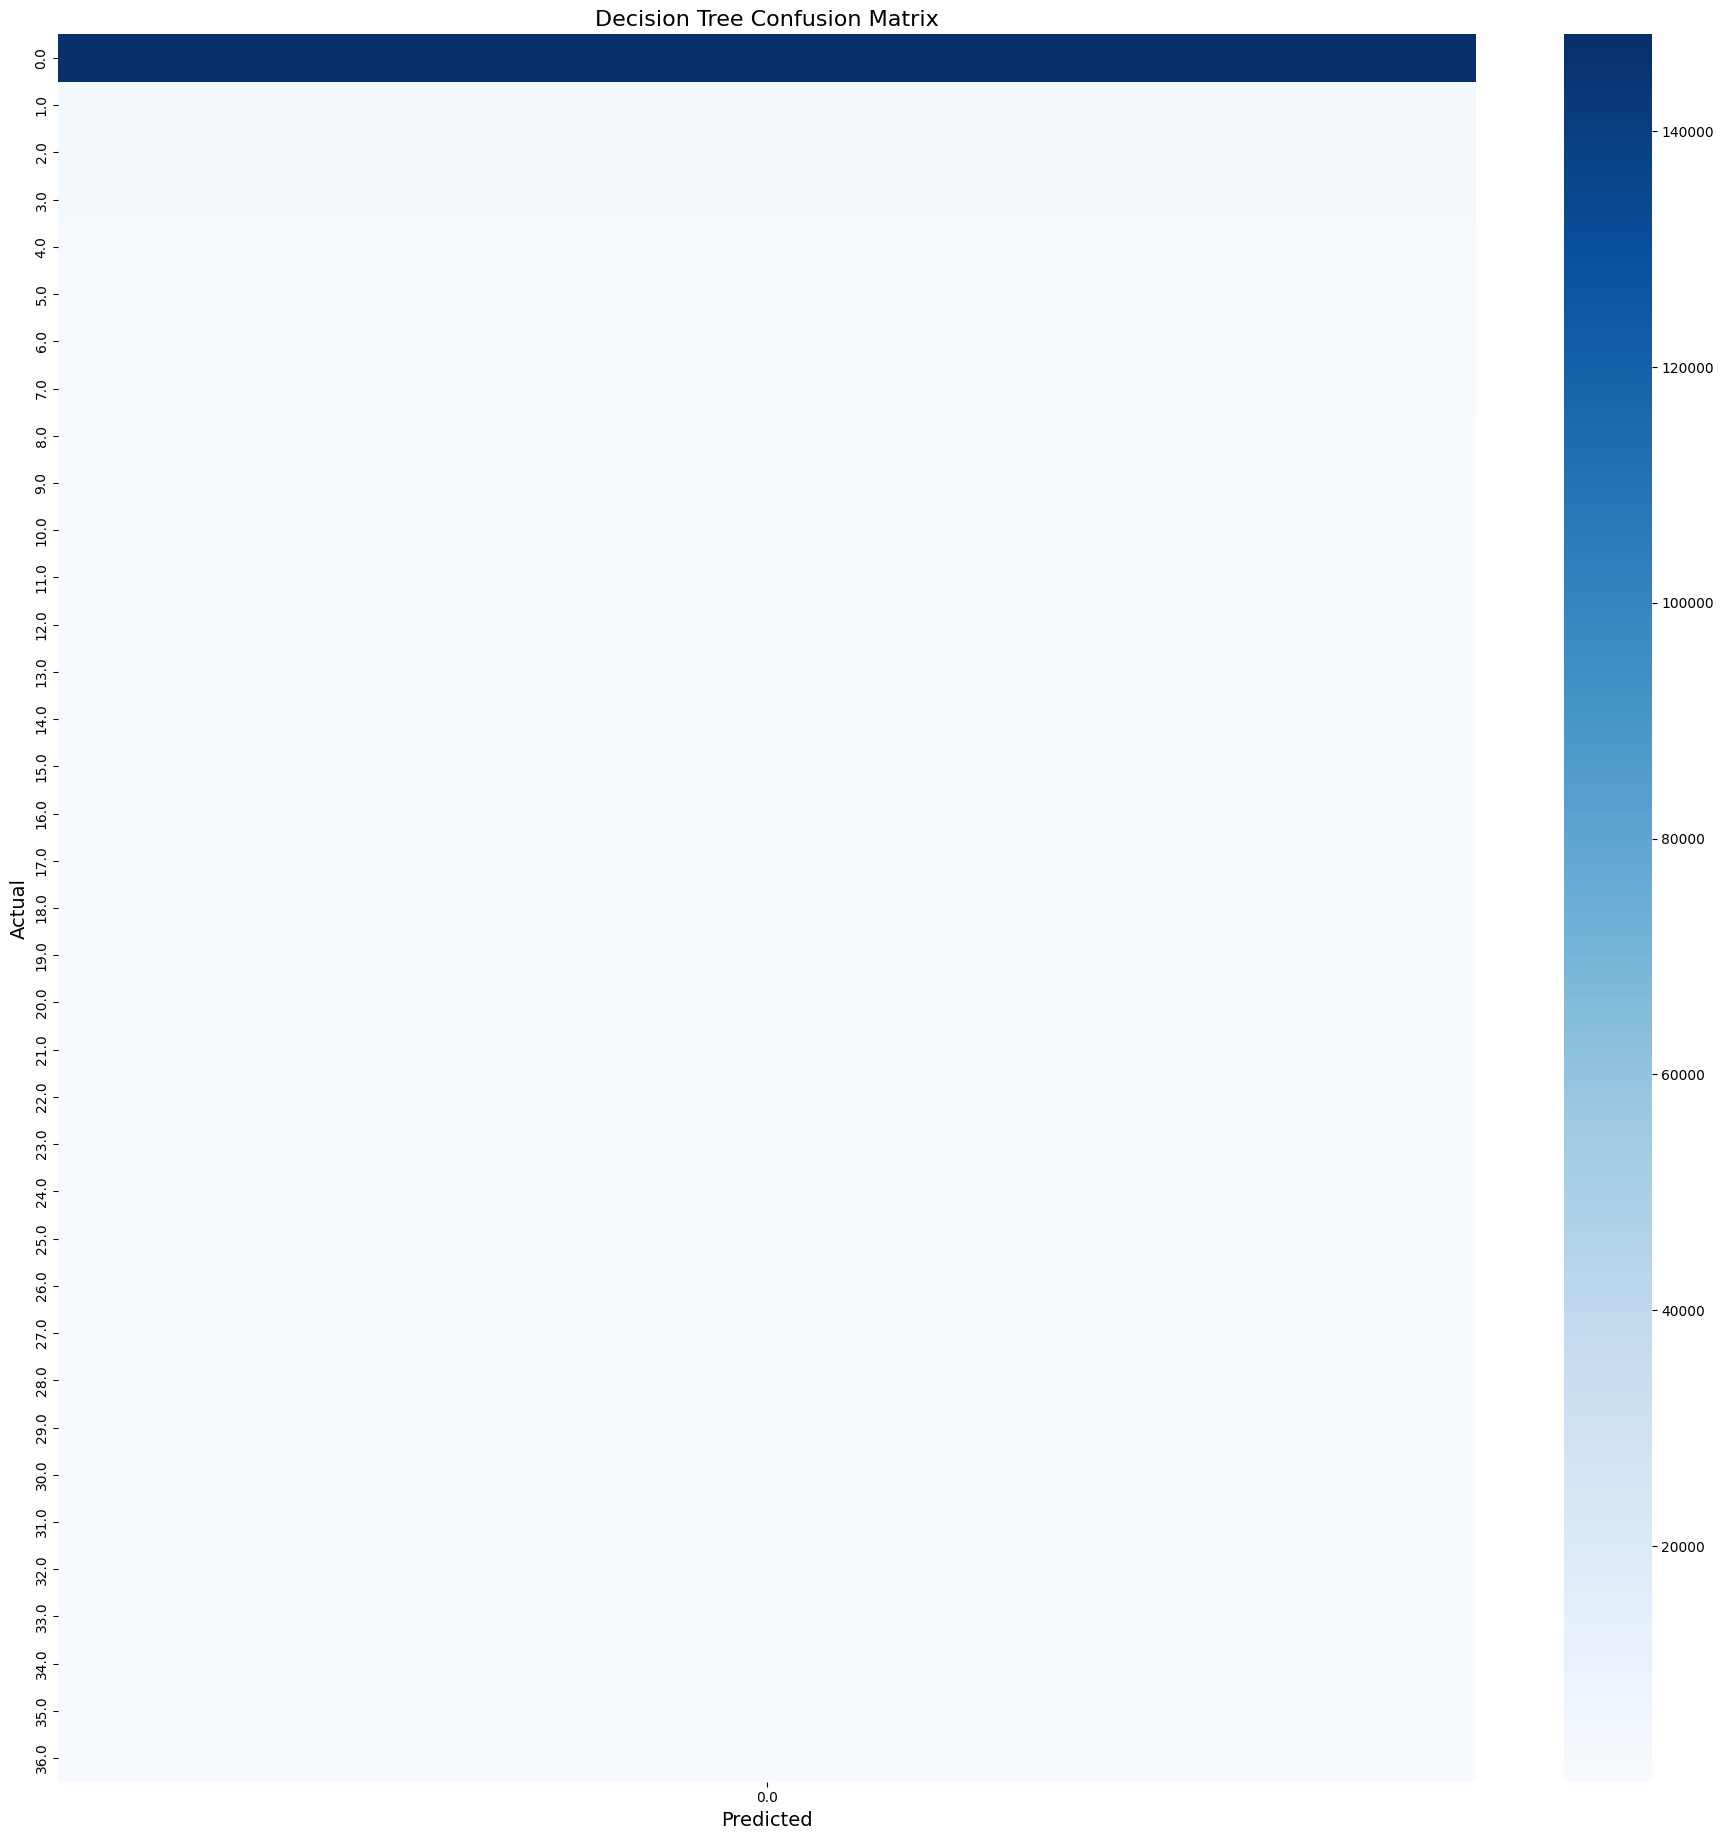

In [159]:
import seaborn as sns

df.groupBy("Country").agg({"Quantity": "mean", "UnitPrice": "mean"}).show()
df.groupBy("Country").count().orderBy("count", ascending=False).show()




plt.figure(figsize=(max(6, num_labels * 0.5), max(5, num_labels * 0.5)))
sns.heatmap(pivot_dt, annot=False, fmt="g", cmap="Blues")  # annot=True 
plt.title('Decision Tree Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.tight_layout()
plt.show()
